# Making Protein Structure Clustering Figures

We already have other notebooks for exploring and analyzing the DALI protein structure clustering analysis data - namely `DALI_data_analysis.ipynb` and `structure_cluster_analysis.ipynb`. I don't want to clutter those notebooks with figures and code to make them look pretty so this notebook is exclusively for making figures and getting them to look exactly how I want them to.

First, the Clustermap (this one is a pain) - let's import and process the similarity matrix, and then create a figure without actually displaying it to save memory.

In [1]:
import numpy as np
import dash_bio
import plotly.express as px

#We need to skip the first column and the first row of the input file since this is where the labels are
columns = tuple(range(1, 952))
similarity_matrix = np.loadtxt("../DALI/ordered", usecols=columns, skiprows=1)

#The first 130 columns contain structures with low similarity to all the rest so I've manually removed these into their own cluster
similar_submatrix = similarity_matrix[130:, 130:]

heatmap_colours = px.colors.sequential.Purples

fig = dash_bio.Clustergram(
    data=similar_submatrix,
    color_map=heatmap_colours,
    color_threshold={
        "row": 150,
        "col": 150
    },
    hidden_labels=["row", "col"],
    width=1200,
    height=800,
    paper_bg_color="#FFFFFF"
)

By looping through the figure's `data` key we can see that each dendrogram point has a defined colour:

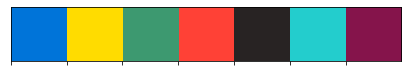

In [2]:
from plotly.exceptions import PlotlyKeyError
import seaborn as sns

all_colours = []

for data_point in fig["data"]:
    try:
        all_colours.append(data_point["marker"]["color"])
    except PlotlyKeyError:
        continue

colour_tuples = set(all_colours)
colour_tuples = np.array([tuple([int(item) for item in colour.split("(")[1][:-1].split(",")]) for colour in colour_tuples]) / 255
sns.palplot(colour_tuples)

This is the colour palette we'd like to use, `plotly.express.colors.qualitative.Dark24`:

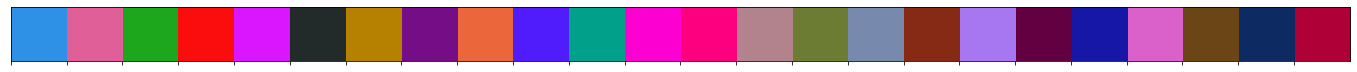

In [3]:
cluster_colours = px.colors.qualitative.Dark24
colour_tuples = cluster_colours
colour_tuples = np.array([tuple(int(colour[i+1:i+3], 16) for i in (0, 2, 4)) for colour in colour_tuples]) / 255
sns.palplot(colour_tuples)

We can loop through the data points and replace colours at will, but there's an issue. We can replace that root blue colour with any colour we choose, but ideally we'd like a different colour for each cluster - this is tough since in the original figure the colours cycle and so multiple clusters share the same colour.

In [4]:
for i, data_point in enumerate(fig["data"][:20]):
    print(data_point["marker"]["color"])

rgb(0,116,217)
rgb(61,153,112)
rgb(61,153,112)
rgb(0,116,217)
rgb(61,153,112)
rgb(61,153,112)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)
rgb(255,65,54)


In [5]:
blue = "rgb(0,116,217)"

seen_colours = []
prev_colour = ""

new_fig = fig

for data_point in new_fig["data"]:
    try:
        colour = data_point["marker"]["color"]
    except PlotlyKeyError:
        continue

    if colour == blue:
        data_point["marker"]["color"] = cluster_colours[0]
        continue
    
    elif colour != prev_colour:
        seen_colours.append(colour)
        prev_colour = colour

    try:
        data_point["marker"]["color"] = cluster_colours[len(seen_colours) - seen_colours[::-1].index(colour)]
    except IndexError:
        data_point["marker"]["color"] = cluster_colours[-1]

In [6]:
new_fig.update_layout(width=1200, height=900)
new_fig.write_image("../plots/fig3_clustermap.svg")
# new_fig

Now let's also plot that length vs pI graph with the clusters labelled:

In [7]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

#Load all of our encapsulin hit sequences into a dictionary for access
seq_record_dict = {str(record.id).split()[0]: str(record.seq) for record in SeqIO.parse("../seqs/encapsulin_hits_filtered.fasta", "fasta")}

#Add the experimentally solved structures to this dictionary
for record in SeqIO.parse("../seqs/experimental.fasta", "fasta"):
    seq_record_dict[str(record.id)] = str(record.seq)

def get_sequence_length(mgyp):
    return(len(seq_record_dict[mgyp]))

def get_sequence_pI(mgyp):
    return(ProteinAnalysis(seq_record_dict[mgyp].replace("X", "")).isoelectric_point())

In [8]:
def get_opacity(cluster):
    if cluster in ['1' '10' '11' '16' '3' '4' '6' '7' '8' 'Dissimilar']:
        return 0.8
    else:
        return 0.7

In [15]:
import pandas as pd 
import plotly.graph_objects as go 

colours = cluster_colours

cluster_df = pd.read_csv("../metadata/DALI_cluster_table_2.csv")
cluster_df["Annotated"] = cluster_df["Cluster"].apply(get_opacity)

fig = px.scatter(cluster_df[cluster_df["Cluster"] != "Dissimilar"], x="Length", y="pI", color="Cluster", color_discrete_sequence=colours, labels=dict(Length="Length (Amino Acids)", pI="Isoelectric Point"))

fig.add_trace(go.Scatter(x=[480,480,520,520,480], y=[4.6,5.7,5.7,4.6,4.6], mode="lines", line=go.scatter.Line(color=colours[9]), showlegend=False))
fig.add_trace(go.Scatter(x=[260,260,280,280,260], y=[4.4,5.6,5.6,4.4,4.4], mode="lines", line=go.scatter.Line(color=colours[8]), showlegend=False))
fig.add_trace(go.Scatter(x=[298,298,310,310,298], y=[4.3,6,6,4.3,4.3], mode="lines", line=go.scatter.Line(color=colours[1]), showlegend=False))
fig.add_trace(go.Scatter(x=[385,385,405,405,385], y=[4,7.5,7.5,4,4], mode="lines", line=go.scatter.Line(color=colours[6]), showlegend=False))



# for natural_structure in ["T_maritima_T1", "S_elongatus_T1", "M_xanthus_T3", "Q_thermotolerans_T4"]:
#     x = get_sequence_length(natural_structure)
#     y = get_sequence_pI(natural_structure)
#     cluster = int(cluster_df[cluster_df["MGYP"] == natural_structure]["Cluster"].values[0])

#     fig.add_annotation(x=x, y=y,
#             text=natural_structure.replace("_", " "),
#             showarrow=True,
#             arrowhead=1,
#             bordercolor="#000000",
#             borderwidth=2,
#             borderpad=2,
#             bgcolor=colours[cluster],
#             opacity=0.8)


fig.update_layout(template="plotly_white", width=1400, height=700, font=dict(size=20))
fig.update_xaxes(range=[200, 600])
fig.show()

In [17]:
fig.write_image("../plots/fig3_scatterplot.svg")